# Image Processing Practice

# 1. Manipulating Exposure and Color Channels

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data

## 1.1 RGB to grayscale

In [2]:
from skimage.color import rgb2gray

In [3]:
original = plt.imread('practice_image.png')
grayscale = rgb2gray(original)

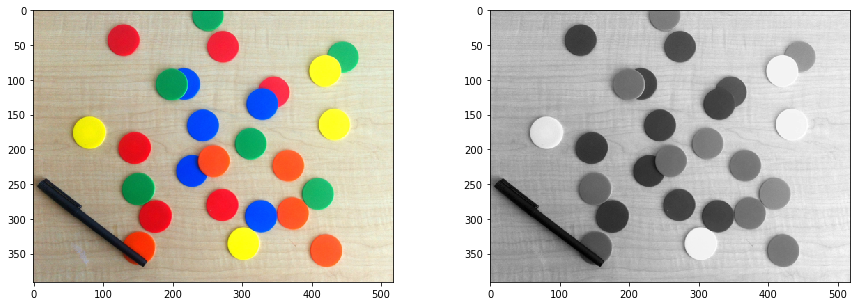

In [4]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
ax = axes.ravel()

ax[0].imshow(original)
ax[1].imshow(grayscale, cmap = plt.cm.gray)

## 1.2 RGB to HSV (Hue, Saturation, Value)

Hue - The attribute of a visual sensation according to which an area appears to be similar to one or combination of the percieced colors.

Saturation - The colorfulness of a stimulus relative to its own brightness.

Value (lightness) - The brightness relative to the brightness of a similarly illuminated white.

In [5]:
from skimage.color import rgb2hsv

In [6]:
hsv_img = rgb2hsv(original)
hue_img = hsv_img[:,:,0]
sat_img = hsv_img[:,:,1]
val_img = hsv_img[:,:,2]

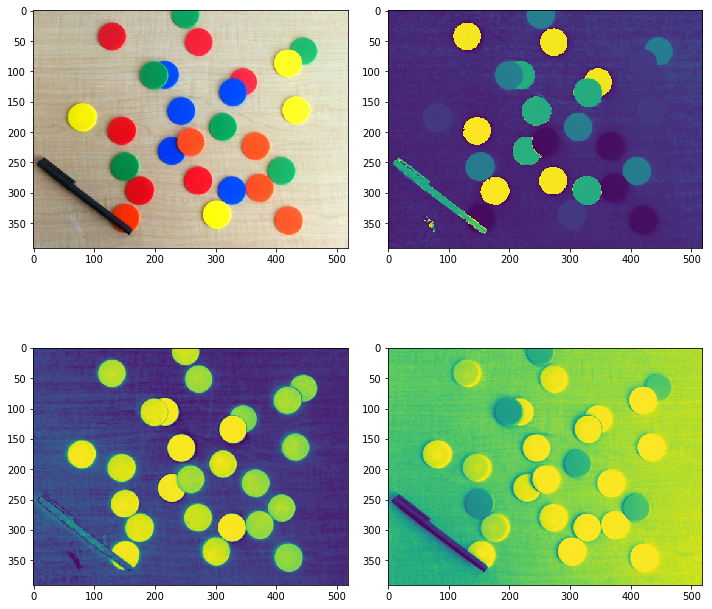

In [7]:
fig, axes = plt.subplots(2,2, figsize=(10,10))
ax = axes.ravel()

ax[0].imshow(original)
ax[1].imshow(hue_img)
ax[2].imshow(sat_img)
ax[3].imshow(val_img)

fig.tight_layout()

In [8]:
#Green coins

hue_threshold_low = 0.4
hue_threshold_high = 0.45

binary_img = (hue_img > hue_threshold_low) & (hue_img < hue_threshold_high)

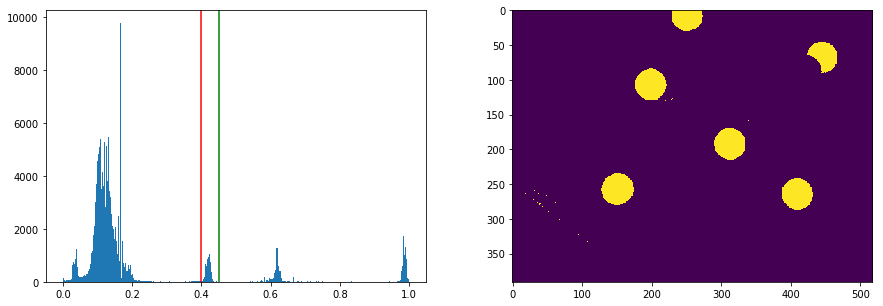

In [9]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
ax = axes.ravel()

ax[0].hist(hue_img.ravel(),bins=512)
ax[0].axvline(x = hue_threshold_low, color='r')
ax[0].axvline(x = hue_threshold_high, color='g')
ax[1].imshow(binary_img)

## 1.3 Immunohistochemical staining colors separation using Intensity

This method is called color deconvolution. FHL2 protien is revealed here with DAB which gives a brown color

In [10]:
from skimage import data
from skimage.color import rgb2hed
from matplotlib.colors import LinearSegmentedColormap
from skimage.exposure import rescale_intensity

In [11]:
cmap_hema = LinearSegmentedColormap.from_list('cmap', ['white', 'navy'])
cmap_dab = LinearSegmentedColormap.from_list('cmap', ['white', 'saddlebrown'])
cmap_eos = LinearSegmentedColormap.from_list('cmap', ['darkviolet','white'])

In [12]:
ihc_rgb = data.immunohistochemistry()
ihc_hed = rgb2hed(ihc_rgb)

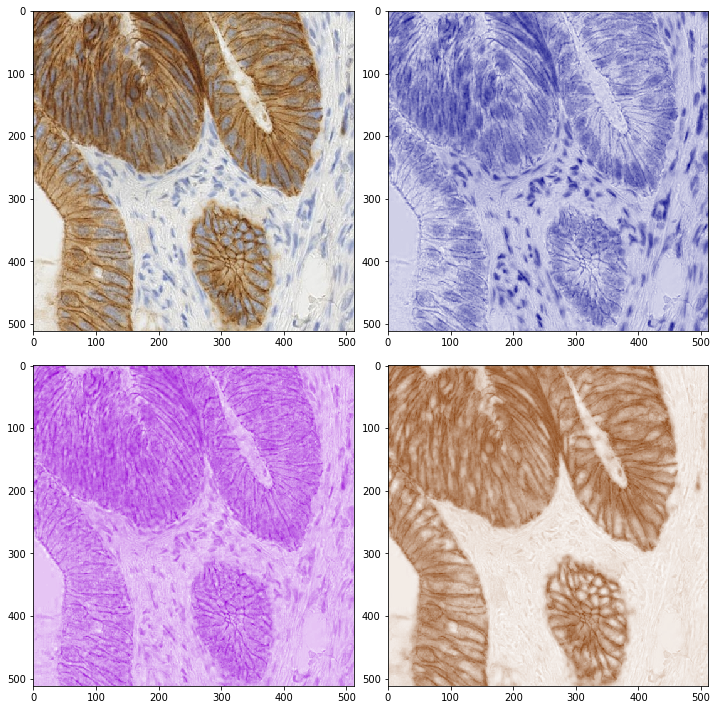

In [13]:
fig, axes = plt.subplots(2,2, figsize=(10,10))
ax = axes.ravel()

ax[0].imshow(ihc_rgb)
ax[1].imshow(ihc_hed[:,:,0], cmap=cmap_hema)
ax[2].imshow(ihc_hed[:,:,1], cmap=cmap_eos)
ax[3].imshow(ihc_hed[:,:,2], cmap=cmap_dab)

fig.tight_layout()

In [14]:
# Here, you can see that the stains are from the hema image and the non-stain part is in the dab. 
# We rescale the h, d pixel intensity between 0 to 1.
# Next we remove the red by using a zero array, highlight d as green and highlight h as blue.

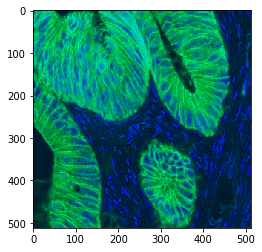

In [15]:
h = rescale_intensity(ihc_hed[:,:,0], out_range=(0,1))
d = rescale_intensity(ihc_hed[:,:,2], out_range=(0,1))

zdh = np.dstack((np.zeros_like(h), d, h))

plt.imshow(zdh)

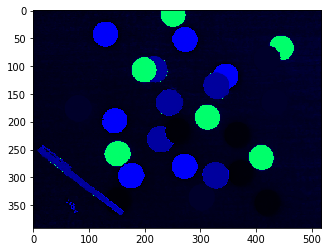

In [16]:
# Same thing can be done with the binary image we made before

g = 1*binary_img

new_img = np.dstack((np.zeros_like(hue_img), g, hue_img))
plt.imshow(new_img)

# Filtering Regional Maximas *

Objective is to use morphological reconstruction to create a background image which can be subtracted from the original image to isolate bright features (regional maxima). First we reconstruct by dilation starting at the edges of the image.

In [259]:
from scipy.ndimage import gaussian_filter
from skimage import img_as_float
from skimage.morphology import reconstruction

In [319]:
image = gaussian_filter(img_as_float(original), 0.5)   #import for subtraction

In [320]:
mask = image

In [328]:
r = image[:,:,0]
g = image[:,:,1]
b = image[:,:,2]

constant = 0.9

seed = rescale_intensity((r > constant) | (g > constant) | (b > constant), (0,0.2))

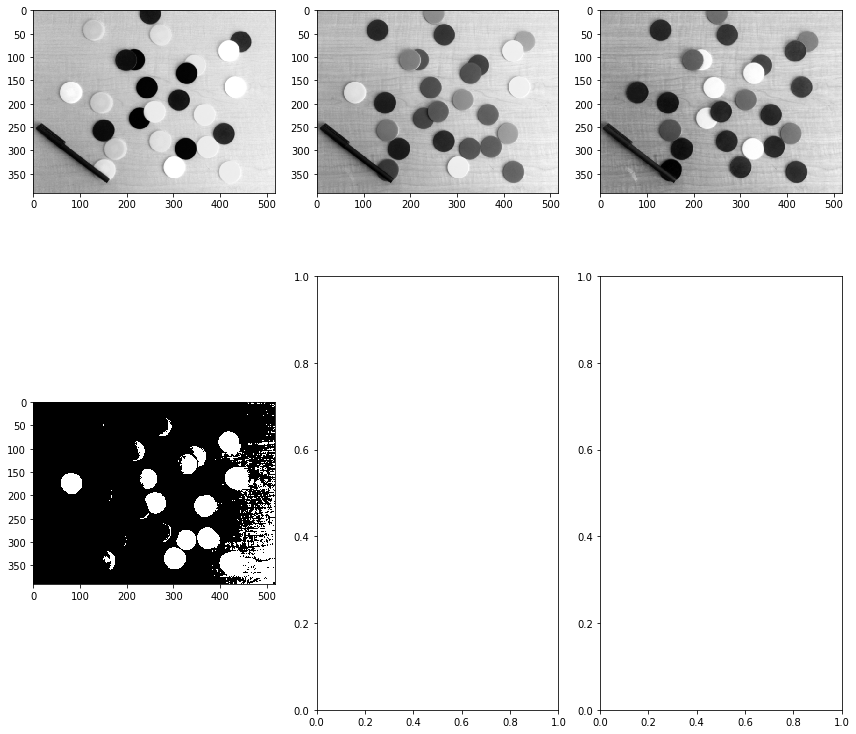

In [329]:
fig, axes = plt.subplots(2,3, figsize = (12,12))
ax = axes.ravel()

ax[0].imshow(image[:,:,0], cmap=plt.cm.gray)
ax[1].imshow(image[:,:,1], cmap=plt.cm.gray)
ax[2].imshow(image[:,:,2], cmap=plt.cm.gray)
ax[3].imshow(seed, cmap=plt.cm.gray)

fig.tight_layout()

In [309]:
dilated = reconstruction(seed, mask, method='dilation')

AssertionError: 

In [255]:
h = 0.4
seed = image - h
dilated = reconstruction(seed, mask, method='dilation')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


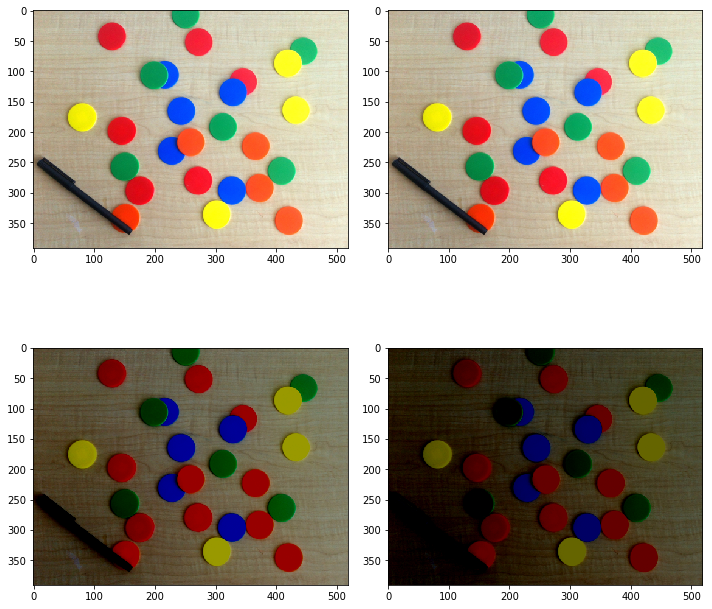

In [256]:
fig, axes = plt.subplots(2,2, figsize=(10,10))
ax = axes.ravel()

ax[0].imshow(original)
ax[1].imshow(image)
ax[2].imshow(seed)
ax[3].imshow(image-dilated)

fig.tight_layout()

# Local Histogram Equalization

In [127]:
from skimage import data
from skimage import exposure

In [128]:
image = data.moon()

In [129]:
global_eq_image = exposure.equalize_hist(image)

In [627]:
from skimage.filters import rank
from skimage.morphology import disk

selem = disk(50)
local_eq_image = rank.equalize(image, selem)

In [131]:
def plot_hist(ax, image):
    ax.plot(exposure.histogram(image)[0])
    ax2 = ax.twinx()
    ax2.plot(exposure.cumulative_distribution(image)[0], 'r')
    return

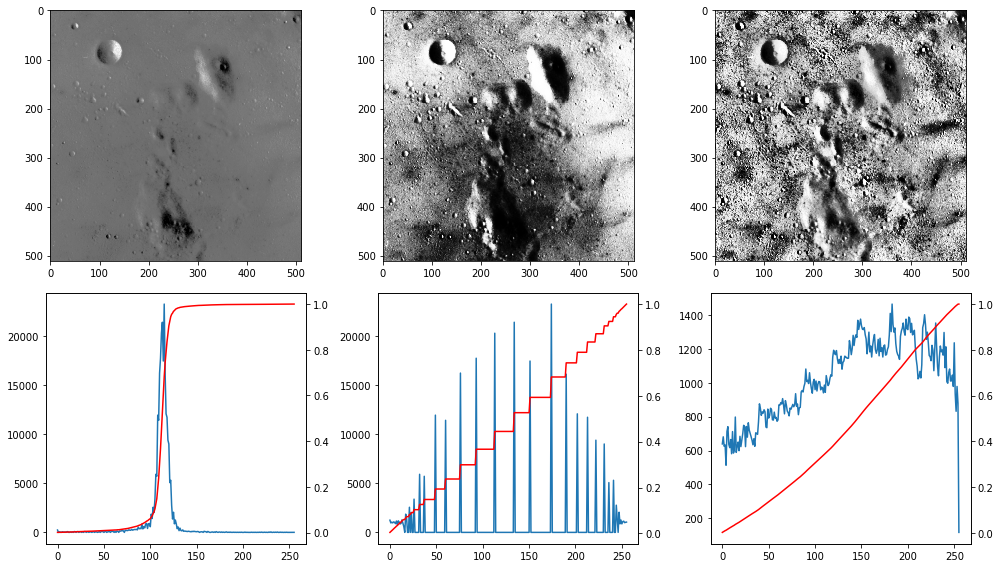

In [132]:
fig, axes = plt.subplots(2,3, figsize=(14,8))
ax = axes.ravel()

ax[0].imshow(image, cmap = plt.cm.gray)
ax[1].imshow(global_eq_image, cmap = plt.cm.gray)     #Global equilization
ax[2].imshow(local_eq_image, cmap = plt.cm.gray)
plot_hist(ax[3], image)
plot_hist(ax[4], global_eq_image)
plot_hist(ax[5], local_eq_image)

fig.tight_layout()

# Gamma & log contrast adjustment

In [208]:
gamma_corrected = exposure.adjust_gamma(img,0.4)
logarithmic_corrected = exposure.adjust_log(img, 5)

In [209]:
def plot_hist(ax, img):
    ax.plot(exposure.histogram(img)[0])
    ax2 = ax.twinx()
    ax2.plot(exposure.cumulative_distribution(img)[0], 'r')
    return

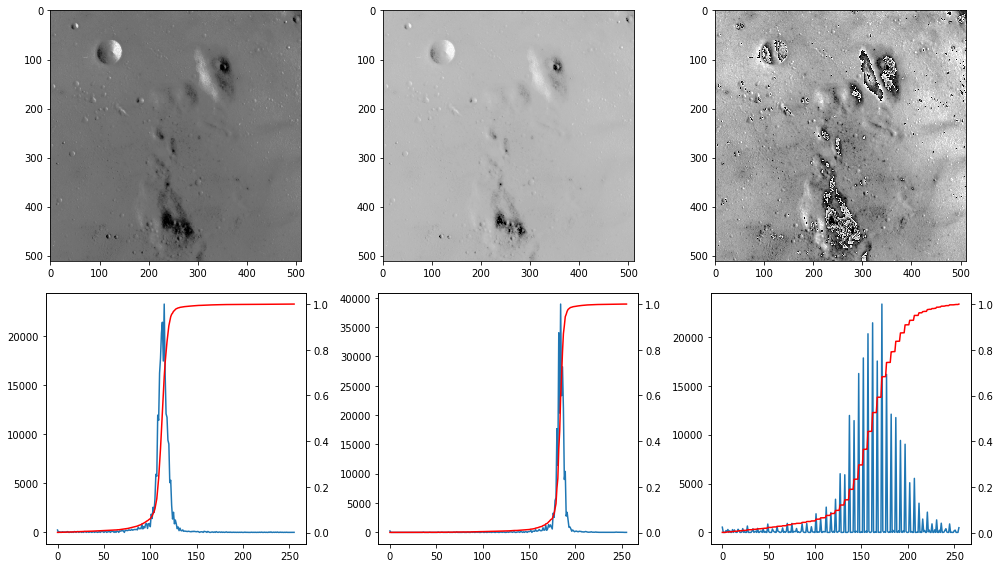

In [210]:
fig, axes = plt.subplots(2,3,figsize=(14,8))
ax = axes.ravel()

ax[0].imshow(img, cmap = plt.cm.gray)
ax[1].imshow(gamma_corrected, cmap = plt.cm.gray)
ax[2].imshow(logarithmic_corrected, cmap = plt.cm.gray)
plot_hist(ax[3], img)
plot_hist(ax[4], gamma_corrected)
plot_hist(ax[5], logarithmic_corrected)

fig.tight_layout()

# Alternatives to histogram equilization

In [212]:
img = data.moon()
hist_eq_img = exposure.equalize_hist(img) #Histogram equilization (global)

p2 = np.percentile(img, 2)
p98 = np.percentile(img, 98)
cont_stret_img = exposure.rescale_intensity(img, in_range=(p2, p98))   #Contrast stretching

adap_eq_img = exposure.equalize_adapthist(img, clip_limit=0.03) #Adaptive equilization

In [216]:
def plot_hist(ax, img):
    ax.plot(exposure.histogram(img)[0])
    ax2 = ax.twinx()
    ax2.plot(exposure.cumulative_distribution(img)[0], 'r')
    return

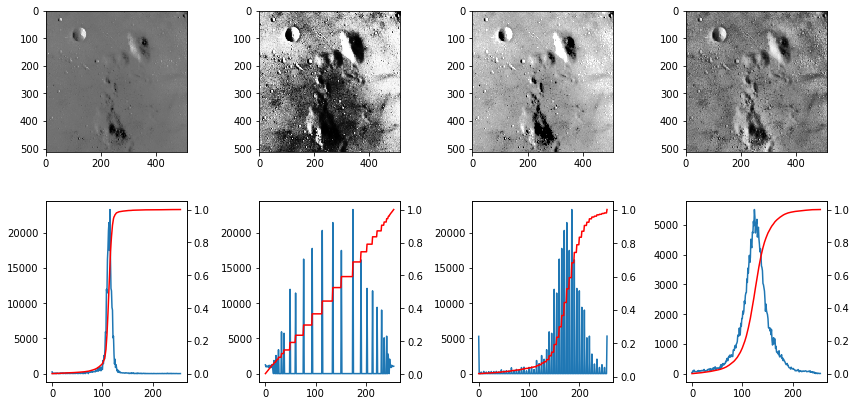

In [219]:
fig, axes = plt.subplots(2,4, figsize = (12,6))
ax = axes.ravel()

ax[0].imshow(img, cmap=plt.cm.gray)
ax[1].imshow(hist_eq_img, cmap=plt.cm.gray)
ax[2].imshow(cont_stret_img, cmap=plt.cm.gray)
ax[3].imshow(adap_eq_img, cmap=plt.cm.gray)
plot_hist(ax[4], img)
plot_hist(ax[5], hist_eq_img)
plot_hist(ax[6], cont_stret_img)
plot_hist(ax[7], adap_eq_img)

fig.tight_layout()

# Tinting grayscale

In [223]:
from skimage import color

In [224]:
image = data.camera()
color_image = color.gray2rgb(image)

In [226]:
red_multiplier = [1,0,0]
yel_multiplier = [1,1,0]

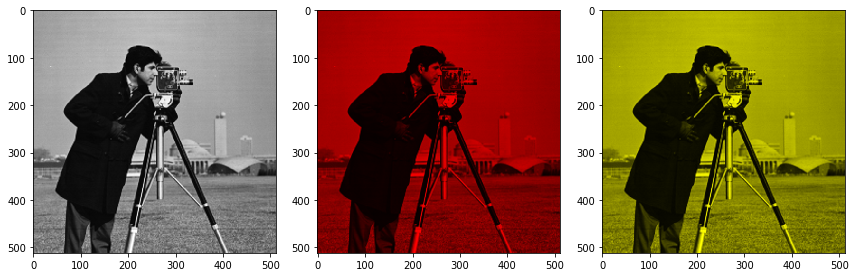

In [235]:
fig, axes = plt.subplots(1,3, figsize=(12,4))
ax = axes.ravel()

ax[0].imshow(color_image)
ax[1].imshow(red_multiplier*color_image)
ax[2].imshow(yel_multiplier*color_image)

fig.tight_layout()

# PART 2

## Contour finding

In [612]:
from skimage import measure
from skimage import img_as_float
from skimage.color import rgb2gray, rgb2hsv
from skimage import exposure

In [613]:
image = plt.imread('practice_image.png')
hsv_img = rgb2hsv(image)
sat_img = hsv_img[:,:,1]

#adaptive eq
gamma_corrected = exposure.adjust_gamma(sat_img,2)

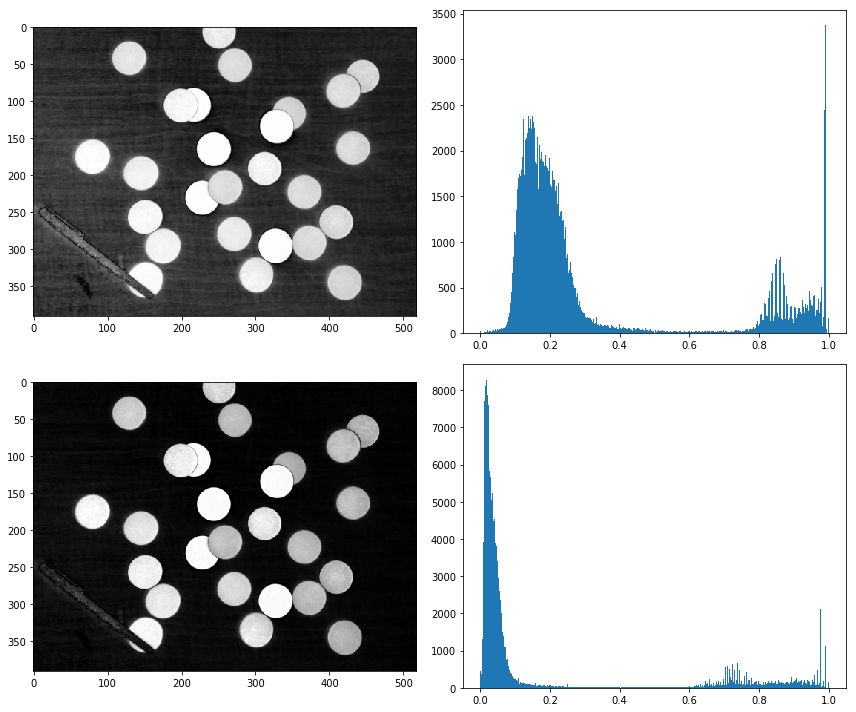

In [615]:
fig, axes = plt.subplots(2,2, figsize=(12,10))
ax = axes.ravel()

ax[0].imshow(sat_img, cmap=plt.cm.gray)
ax[1].hist(sat_img.ravel(), bins=512)
ax[2].imshow(gamma_corrected, cmap=plt.cm.gray)
ax[3].hist(gamma_corrected.ravel(), bins=512)

fig.tight_layout()

In [419]:
contours = measure.find_contours(gamma_corrected,0.6)

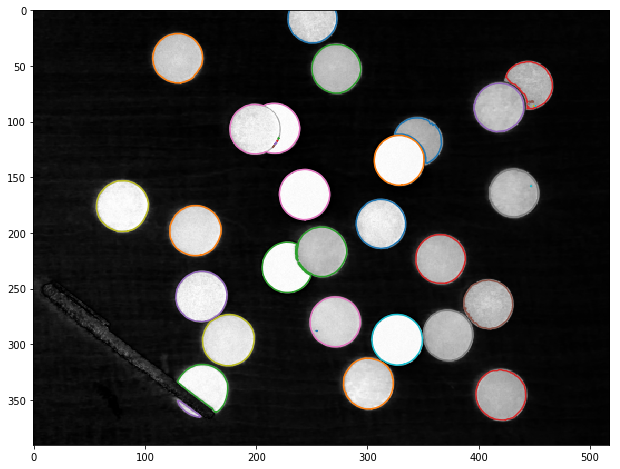

In [429]:
fig, ax = plt.subplots(figsize=(14,8))
ax.imshow(gamma_corrected, cmap = plt.cm.gray)

for i in range(len(contours)):
    ax.plot(contours[i][:,1], contours[i][:,0])

# Convex Hull

https://blogs.mathworks.com/steve/2011/10/04/binary-image-convex-hull-algorithm-notes/

In [619]:
from skimage.util import invert
from skimage.morphology import convex_hull_image
from skimage import img_as_float
from skimage import data
from scipy.ndimage import gaussian_filter

In [617]:
# Load image
image = data.camera()

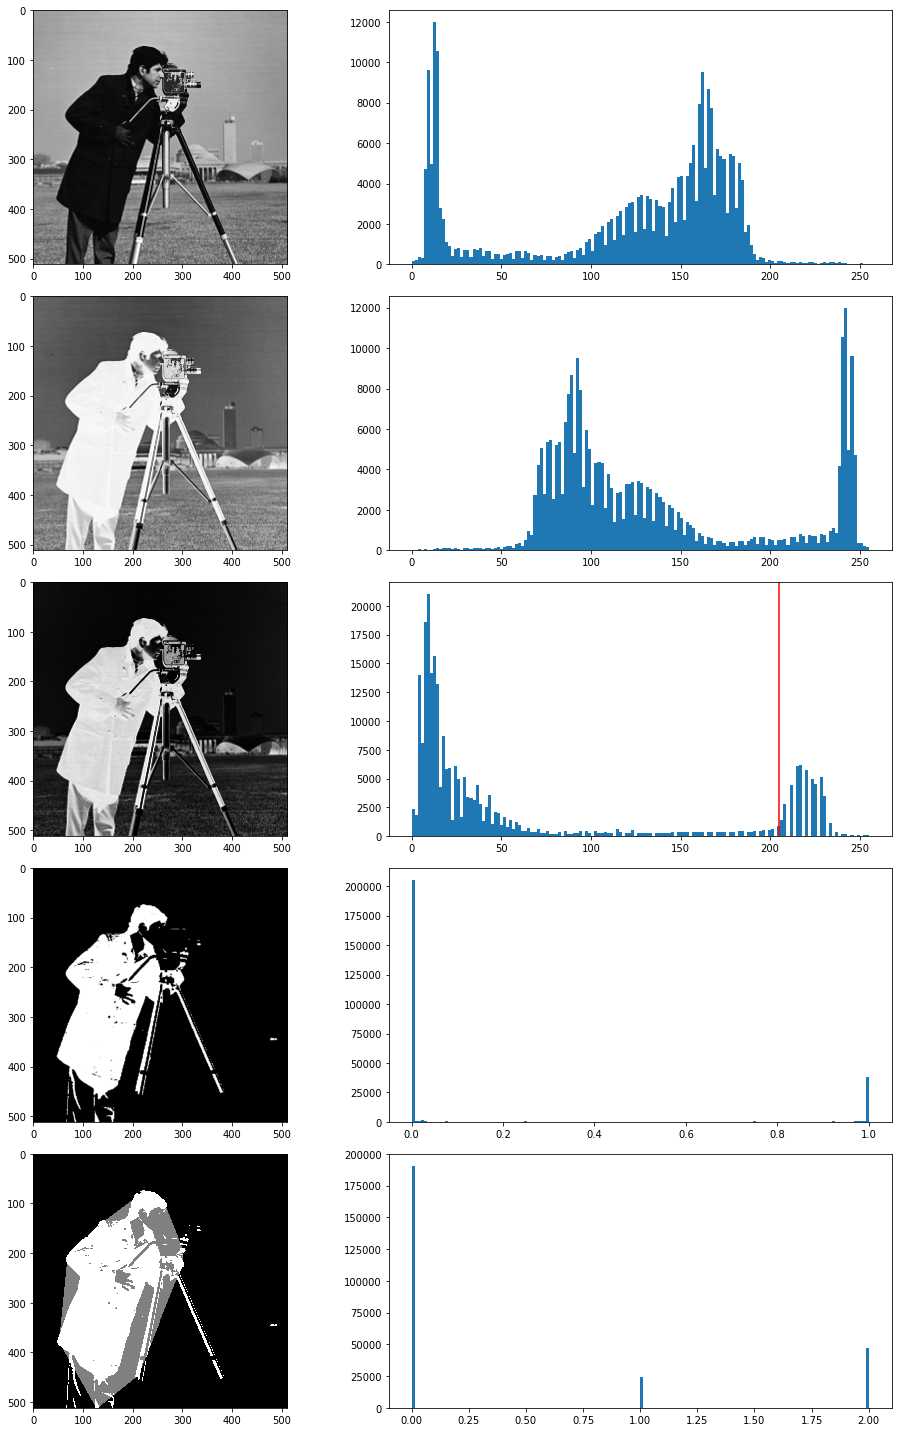

In [623]:
#Creating a binary image using thresholding
fig, axes = plt.subplots(5,2, figsize=(14,20))
ax = axes.ravel()

#Main image & hist
ax[0].imshow(image, plt.cm.gray)
ax[1].hist(image.ravel(), bins=150)

#HSV transforms
inverted = invert(image)
ax[2].imshow(inverted, plt.cm.gray)
ax[3].hist(inverted.ravel(), bins=150)

#Gamma correction
gamma_corrected = exposure.adjust_gamma(inverted,3)
ax[4].imshow(gamma_corrected, plt.cm.gray)
ax[5].hist(gamma_corrected.ravel(), bins=150)
ax[5].axvline(x=205, color='r')

#Binarization with gaussian filter to remove small white points that cause bias
binary_image = (gamma_corrected > 205) #& (image < 25)
mask = gaussian_filter(img_as_float(binary_image),0.8)

ax[6].imshow(mask, plt.cm.gray)
ax[7].hist(mask.ravel(), bins=150)

#Convex hull

chull = convex_hull_image(mask)
chull_diff = img_as_float(chull.copy())
chull_diff[binary_image] = 2

ax[8].imshow(chull_diff, cmap=plt.cm.gray)
ax[9].hist(chull_diff.ravel(), bins=150)

fig.tight_layout()

In [624]:
#######################

# Morphological - 
# 1. Opening
# 2. Closing
# 3. Erosion 
# 4. Dilation

# Canny Edge detector

In [626]:
from scipy import ndimage as ndi
from skimage import feature

In [648]:
image = data.moon()

In [649]:
edges1 = feature.canny(image)
edges2 = feature.canny(image, sigma=2)
edges3 = feature.canny(image, sigma=3)
edges4 = feature.canny(image, sigma=4)
edges5 = feature.canny(image, sigma=5)

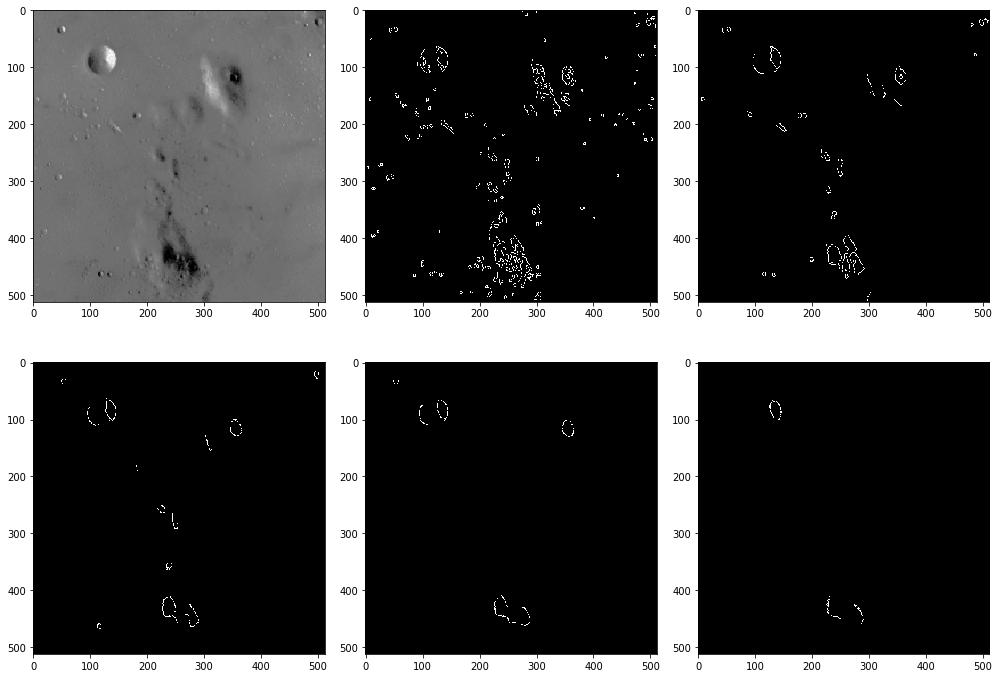

In [651]:
fig, axes = plt.subplots(2,3,figsize=(14,10))
ax = axes.ravel()


ax[0].imshow(image , plt.cm.gray)
for i in range(1,6):
    ax[i].imshow(vars()['edges'+str(i)] , plt.cm.gray)

fig.tight_layout()

# Active Contour model

Watch this - https://www.youtube.com/watch?v=RJEMDkhVgqQ&t=1898s

In [837]:
from skimage.segmentation import active_contour
from skimage.filters import gaussian
from skimage.exposure import adjust_gamma

In [840]:
img = adjust_gamma(rgb2gray(plt.imread('game_img1.jpg')),2)

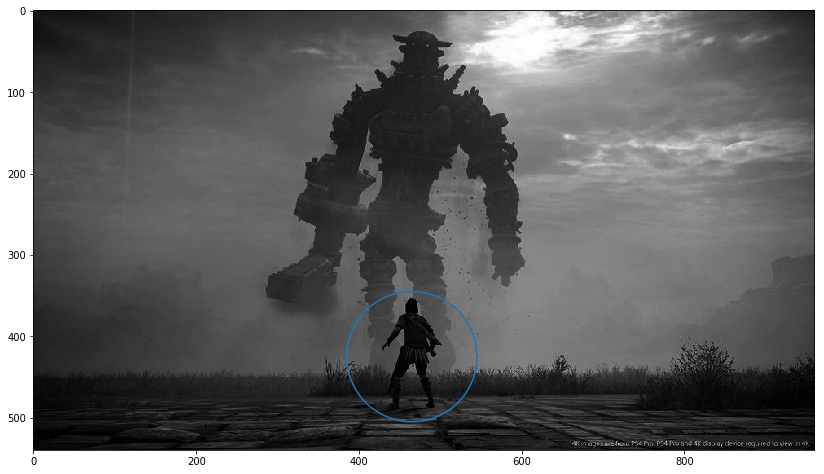

In [846]:
s = np.linspace(0,2*np.pi, 400)    #400 points in pi
x = 465+80*np.cos(s)               #Tweek the numbers to match the area
y = 425+80*np.sin(s)

fig, ax = plt.subplots(1,1,figsize=(14,14))
ax.imshow(img, plt.cm.gray)
ax.plot(x,y)

#Define as init
init = np.array([x,y]).T

In [871]:
snake = active_contour(gaussian(img,3), init, alpha=0.05, 
                       bc='periodic', gamma=0.008, beta=0.4, 
                       w_edge=0.8, w_line=-0.3)

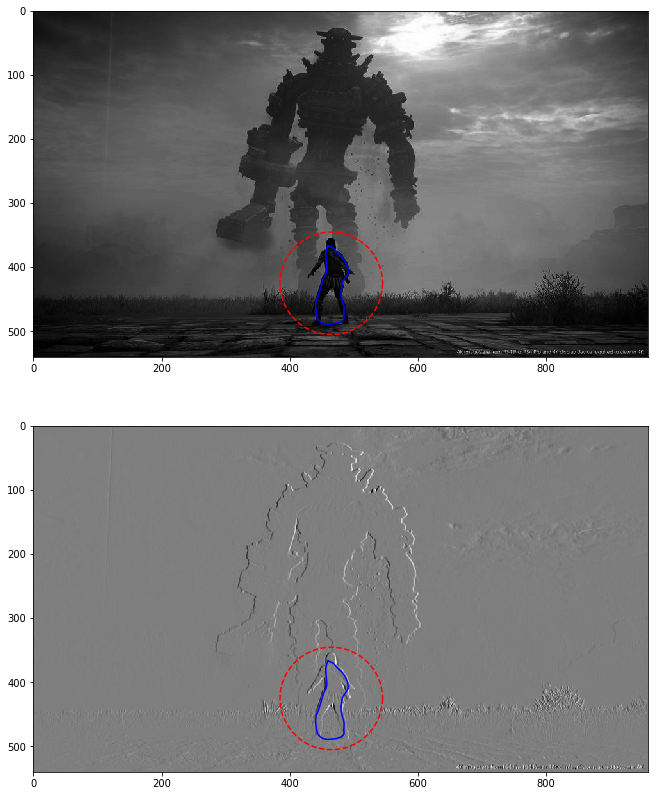

In [873]:
fig, axes = plt.subplots(2,1,figsize=(14,14))
ax = axes.ravel()


ax[0].imshow(img, plt.cm.gray)
ax[0].plot(init[:,0],init[:,1], '--r')
ax[0].plot(snake[:,0], snake[:,1], '-b')

ax[1].imshow(filters.sobel_v(img), plt.cm.gray)
ax[1].plot(init[:,0],init[:,1], '--r')
ax[1].plot(snake[:,0], snake[:,1], '-b')

In [652]:
img = data.text()

In [658]:
x = np.linspace(5,424,100)
y = np.linspace(136,50,100)
init = np.array([x,y]).T

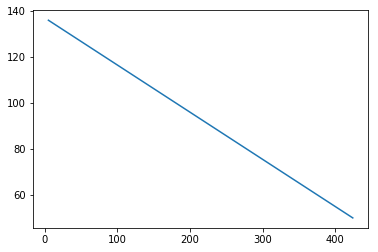

In [659]:
plt.plot(x,y)

In [673]:
snake = active_contour(gaussian(img,1), init, alpha=0.1, bc='fixed', beta=1.0, w_line=-5, w_edge=0, gamma=0.1)

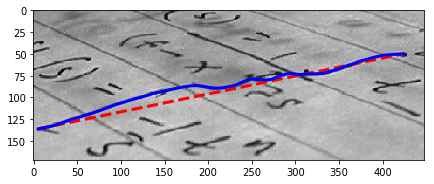

In [674]:
fig, ax = plt.subplots(figsize=(7,7))

ax.imshow(img, plt.cm.gray)
ax.plot(init[:,0], init[:,1], '--r', lw=3)
ax.plot(snake[:,0], snake[:,1], '-b', lw=3)

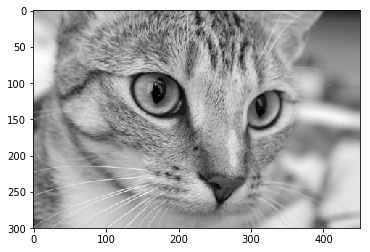

In [680]:
image = data.chelsea()
gray_img = rgb2gray(image)

plt.imshow(gray_img, plt.cm.gray)

In [687]:
from skimage import filters
sobel_img = filters.sobel(gray_img)
sobel_h_img = filters.sobel_h(gray_img)
sobel_v_img = filters.sobel_v(gray_img)

In [683]:
sobel_img.shape

(300, 451)

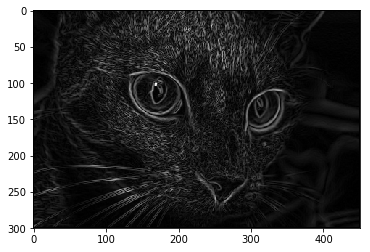

In [684]:
plt.imshow(sobel_img, plt.cm.gray)

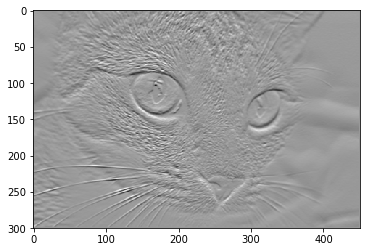

In [689]:
plt.imshow(sobel_h_img, plt.cm.gray)

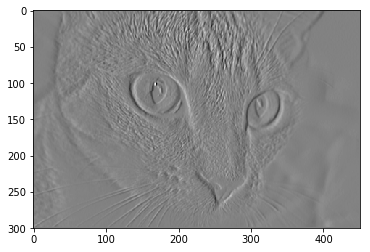

In [690]:
plt.imshow(sobel_v_img, plt.cm.gray)